In [1]:
# Author: James Foster
# Feature Engineering for Television Spoiler Detection

from __future__ import division
import numpy as np
import pandas as pd
import classify
from IPython.core.debugger import Tracer;
%load_ext rpy2.ipython

In [2]:
# Helper functions and classes

from sklearn.base import TransformerMixin
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag, ne_chunk
from nltk.tokenize import SpaceTokenizer
from scipy.sparse import hstack
from collections import defaultdict

# Genre Transformer
class PageGenre(TransformerMixin):
    
    def __init__(self, genre_dict):
        self.genre_dict = genre_dict
    
    def transform(self, X, **transform_params):
        # Given page, lookup genre
        genre_lists = [self.genre_dict[page] for page in X]
        genre_strings = [" ".join(genre_list) for genre_list in genre_lists]
        return genre_strings
        
    def fit(self, X, y=None, **fit_params):
        return self  # does nothing

# Create polynomial features (higher order features and interactions) from 
# most important features identified by select_from_model argument object.
# Optionally keep the less important features without creating polynomials for them
class AddTopPolynomials(TransformerMixin):
    
    def __init__(self, select_from_model, polynomial, keep_rejects=False, sparse=False):
        self.select_from_model = select_from_model
        self.polynomial = polynomial
        self.keep_rejects = keep_rejects
        self.sparse = sparse

    def transform(self, X, **transform_params):
        X_new = self.select_from_model.transform(X)
        #X_poly = self.polynomial.transform(X_new.todense())
        X_poly = self.polynomial.transform(X_new)
        if(self.keep_rejects):
            rejects_mask = [not i for i in self.select_from_model.get_support()]
            if(self.sparse):
                X_rejects = X[:, rejects_mask]
                X_poly = hstack((X_poly, X_rejects))
            else:
                X_rejects = X[:, rejects_mask]
                X_poly = np.hstack((X_poly, X_rejects))
        return X_poly
        
    def fit(self, X, y=None, **fit_params):
        X_new = self.select_from_model.fit_transform(X,y)
        #self.polynomial.fit(X_new.todense())
        self.polynomial.fit(X_new)
        return self  

# Create Word2Vec word representations
# and compute average of words in sentence
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

# Create feature that's a count of words manually selected as likely to indicate spoilers
class ManualWordsFeature(TransformerMixin):

    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.words = set(["dead","die","died", 'dies','dying',"death","kill","killed","suicide","shot", "staked", "stabbed", "finale",
                          'survived', 'survive', 'stab', 'revealed', 'realize','realizes', 'reveal', 'realized', 'ends', 'crucify',
                          'averted', 'averts', 'avert', 'finds', 'finally', 'final', 'alive', 'murder', 'murdered', 
                          'murderer', 'killer', 'learns', 'married', 'marries', 'wedding', 'realizes', 'actually', '!', 'pregnant',
                          'end','ending', 'killing', 'kills', 'eventually', 'reason', 'discover', 'discovered','big',
                          'averted', 'bomb', 'shoot','truth', 'ultimately', 'causes', 'affair', 'captured', 'results','fired'])

    def transform(self, X, **transform_params): 
        manual_words_present = []
        for doc in X:
            doc_prepped = [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
            count = len(self.words.intersection(doc_prepped))
            manual_words_present.append(count)
        return pd.DataFrame(manual_words_present)
    
    def fit(self, X, y=None, **fit_params):
        return self  # does nothing
    

# Remove words in sentence that start with capital letter (not including first word) as a 
# course way to remove named entities/character names
class LowercaseLemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        keep = []
        lemmas = [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
        for i in range(1,len(lemmas)):
            if lemmas[i][0].islower():
                keep.append(lemmas[i])
        return keep

# Lemmatize words using WordNetLemmatizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# Needed as a first step in one-hot-encoding of category strings before passing to DictVectorizer
class DictTransformer(TransformerMixin):
    """Converts passed dataframe column named in constructor to dictionary"""

    def transform(self, X, **transform_params):
        return pd.DataFrame(X).to_dict(orient='records')
        
    def fit(self, X, y=None, **fit_params):
        return self  # does nothing

# Extract column name(s) from passed data frame
class ColumnExtractor(TransformerMixin):
    """Takes in dataframe and returns column(s) passed in constructor"""
    
    def __init__(self, vars):
        self.vars=vars
        
    def transform(self, X):
        return X.loc[:,self.vars]
        
    def fit(self, X, y=None, **fit_params):
        return self

# Convert sparse matrix to dense matrix represenation
class DenseTransformer(TransformerMixin):
    """Takes in sparse matrix and returns dense matrix"""
        
    def transform(self, X):
        return X.todense()  
    
    def fit(self, X, y=None, **fit_params):
        return self

# Read train and test data from file
def read_data(train, test):
    train = pd.read_csv(train, header=0)  
    test = pd.read_csv(test, header=0)
    return train, test    


# TODO
class SpellingCorrector(TransformerMixin):
    """Corrects spelling"""
    
    def __init__(self, vars):
        self.vars=vars
    
    def transform(self, X, **transform_params):
        return 
        
    def fit(self, X, y=None, **fit_params):
        return self  # does nothing
    
        
# TODO: broken
class NamedEntityTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        ne_present = []
        for doc in X:
            doc_toks = word_tokenize(doc)
            pos = pos_tag(doc_toks)
            chunked_nes = ne_chunk(pos) 
            #if len(chunked_nes)>0:
            #    ne_present.append(1)
            #else:
            #    ne_present.append(0)
            ne_present.append(pos)
        #return pd.DataFrame(ne_present)
        return ne_present

    def fit(self, X, y=None, **fit_params):
        return self  # does nothing

In [4]:
# Read in data
train, test = read_data("./data/spoilers/train.csv", "./data/spoilers/test.csv")
pages_train, pages_test = read_data("./data/spoilers/pages_train.csv", "./data/spoilers/pages_test.csv")
train = pd.concat([train, pages_train], axis=1)
test = pd.concat([test, pages_test], axis=1)

# Push data to R
%Rpush train
%Rpush test

train.head()

,sentence,spoiler,verb,page,trope,rating,year,votes,number of seasons
0,He saw me at his surgery.,False,True,Absolutely,ComicallyMissingThePoint,8.6,1989.0,162.0,4.0
1,"Repeats have been rare, but BBC 4 now shows th...",False,True,AdamAdamantLives,TheAvengers.html,6.9,1966.0,137.0,2.0
2,Between his code of chivalry and a bad romanti...,False,True,AdamAdamantLives,CelibateHero,6.9,1966.0,137.0,2.0
3,"Adam drives a Mini Cooper S, a fairly humdrum ...",False,True,AdamAdamantLives,CoolCar,6.9,1966.0,137.0,2.0
4,Later we discover that The Face had himself fr...,False,True,AdamAdamantLives,HumanPopsicle,6.9,1966.0,137.0,2.0


In [7]:
import pickle
genre_dict = pickle.load(open("genre_dict.p", "rb"))

[1] 14784     9
[1] 14388

Call:
lm(formula = spoiler ~ year, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6800 -0.5272  0.3773  0.4346  0.9695 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.860e+01  7.094e-01  -26.21   <2e-16 ***
year         9.552e-03  3.544e-04   26.95   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4872 on 14386 degrees of freedom
  (396 observations deleted due to missingness)
Multiple R-squared:  0.04807,	Adjusted R-squared:  0.04801 
F-statistic: 726.5 on 1 and 14386 DF,  p-value: < 2.2e-16



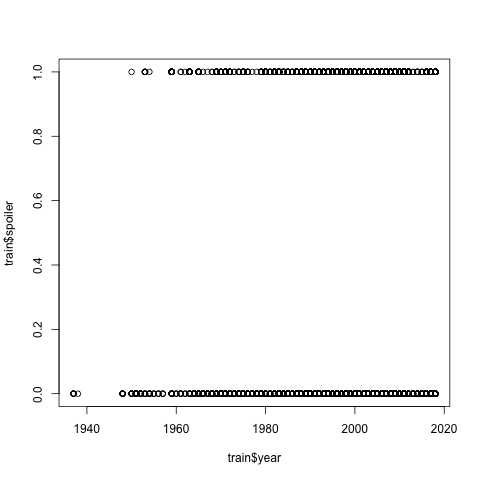

In [8]:
%%R
print(dim(train))
print(sum(!is.na(train$year)))
train$year
plot(train$year, train$spoiler)
summary(lm(spoiler ~ year, data=train))

In [192]:
# Word2Vec
# with open("/usr/lib/glove/glove.6B.200d.txt", "rb") as lines:
#     w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
#            for line in lines}

In [6]:
# Remove NaNs
#train = train.dropna()
#test = test.dropna()
#print train.shape
#print test.shape

# impute missing values in test data
# imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
# imp.fit_transform(test)


,sentence,spoiler,verb,page,trope,rating,year,votes,number of seasons
0,He saw me at his surgery.,False,True,Absolutely,ComicallyMissingThePoint,8.6,1989.0,162.0,4.0
1,"Repeats have been rare, but BBC 4 now shows th...",False,True,AdamAdamantLives,TheAvengers.html,6.9,1966.0,137.0,2.0
2,Between his code of chivalry and a bad romanti...,False,True,AdamAdamantLives,CelibateHero,6.9,1966.0,137.0,2.0
3,"Adam drives a Mini Cooper S, a fairly humdrum ...",False,True,AdamAdamantLives,CoolCar,6.9,1966.0,137.0,2.0
4,Later we discover that The Face had himself fr...,False,True,AdamAdamantLives,HumanPopsicle,6.9,1966.0,137.0,2.0


In [9]:
# Remove tropes not in test data
shared_tropes = set(train['trope']).intersection(set(test['trope']))
shared_tropes
for i,line in test.iterrows():
    #print i, line
    #print line['trope'], test.loc[i,['trope']]
    trope = train.ix[i,'trope']
    if trope not in shared_tropes:
        train.ix[i,'trope'] = 'NotInTest'
train.head()

,sentence,spoiler,verb,page,trope,rating,year,votes,number of seasons
0,He saw me at his surgery.,False,True,Absolutely,NotInTest,8.6,1989.0,162.0,4.0
1,"Repeats have been rare, but BBC 4 now shows th...",False,True,AdamAdamantLives,NotInTest,6.9,1966.0,137.0,2.0
2,Between his code of chivalry and a bad romanti...,False,True,AdamAdamantLives,NotInTest,6.9,1966.0,137.0,2.0
3,"Adam drives a Mini Cooper S, a fairly humdrum ...",False,True,AdamAdamantLives,NotInTest,6.9,1966.0,137.0,2.0
4,Later we discover that The Face had himself fr...,False,True,AdamAdamantLives,NotInTest,6.9,1966.0,137.0,2.0


In [10]:
# Define Pipeline

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
classifier = SGDClassifier(loss='log', penalty='l2', shuffle=True)

# sentenceVectorizer
sentenceVectorizer = TfidfVectorizer(strip_accents = "ascii", lowercase=True)
#sentenceVectorizer = TfidfVectorizer(lowercase=False, tokenizer=LowercaseLemmaTokenizer(), strip_accents = "ascii")
#sentenceVectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1) #bigrams
#tokenizer = LowercaseLemmaTokenizer()
#tokenizer = LemmaTokenizer()
#sentenceVectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1) #bigrams
#sentenceVectorizer = TfidfVectorizer(ngram_range=(1, 3), token_pattern=r'\b\w+\b', min_df=1) #trigrams
#sentenceVectorizer = TfidfVectorizer(lowercase=False, stop_words='english', tokenizer=tokenizer)
#sentenceVectorizer = TfidfVectorizer(analyzer='char')
#sentenceVectorizer = TfidfVectorizer(stop_words='english')
#sentenceVectorizer = TfidfVectorizer()
#sentenceVectorizer = MeanEmbeddingVectorizer(w2v)
#sentenceVectorizer = CountVectorizer(stop_words='english')
#sentenceVectorizer = CountVectorizer()
#sentenceVectorizer = CountVectorizer(analyzer='char')
#sentenceVectorizer = None

# PCA
#pca = PCA(n_components=2000)
#pca = TruncatedSVD(n_components=500)
#pca = None

# Trope
tropeVectorizer = DictVectorizer(sparse=True)

# Genre
genreVectorizer = CountVectorizer()

# IMDb features
imdb_features = ['year', 'rating','votes','number of seasons']

# Select from Model: Restrict features for polynomials/interactions and for final classifier
threshold_polynomial = 6
threshold_classifier = 3
selectFromModel_polynomial = SelectFromModel(estimator=SGDClassifier(loss='log', penalty='l1', shuffle=True), threshold=threshold_polynomial)
selectFromModel_classifier = SelectFromModel(estimator=SGDClassifier(loss='log', penalty='l1', shuffle=True), threshold=threshold_classifier)

# Select K Best: Restrict features for polynomials/interactions and for final classifier
sentence_k = 'all'
trope_k = 'all'
genre_k = 'all'
classifier_k = 'all'

# Polynomial
#polynomial = None
polynomial = PolynomialFeatures(2)
#polynomial = PolynomialFeatures(2, interaction_only=True)
addTopPolynomials = AddTopPolynomials(selectFromModel_polynomial, polynomial, keep_rejects=False, sparse=False)

# Normalization
#standardizer = StandardScaler()
standardizer = MinMaxScaler()

featureUnion = FeatureUnion([
        ('sentence', Pipeline([
            ('extract', ColumnExtractor('sentence')),
            ('vectorizer', sentenceVectorizer),       
#             ('to_dense', DenseTransformer()),
#             ('pca', pca),
            ('select_k', SelectKBest(k=sentence_k)),
      ])),   
        ('manual_words', Pipeline([    
            ('extract', ColumnExtractor('sentence')),       
            ('synonym', ManualWordsFeature()),                       
        ])), 
        ('trope', Pipeline([
            ('extract', ColumnExtractor('trope')),
            ('trope_dict', DictTransformer()),
            ('dummy', tropeVectorizer),
            ('select_k', SelectKBest(k=trope_k)),
        ])),
        ('genre', Pipeline([
            ('extract', ColumnExtractor('page')),    
            ('page_lookup', PageGenre(genre_dict)),
            ('vectorizer', genreVectorizer),
            ('select_k', SelectKBest(k=genre_k)),
       ])),
       ('imdb', Pipeline([
           ('extract', ColumnExtractor(imdb_features)), 
           ('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)),
           #('poly', PolynomialFeatures(2)), 
       ])),
    ])

pipeline = Pipeline([
        ('features', featureUnion),
        ('to_dense', DenseTransformer()),
        ('standardize', standardizer),
        #('add_top_polynomials', addTopPolynomials),
        #('select_from_model_classifier', selectFromModel_classifier),
        #('to_dense', DenseTransformer()), #needed for polynomial transformer or pca
        #('pca', pca),
        #('select_k', SelectKBest(k=classifier_k)),
        ('classifier', classifier)
    ])

In [11]:
# Fit Model to Train Data
limit = .5

# Split train data into train and validation data (also shuffles rows)
from sklearn.model_selection import train_test_split
train_limited = train.sample(frac=limit)
#X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(train_limited, train_limited['spoiler'], test_size=.20)

# Fit pipeline/model to split train set
model = pipeline.fit(X_train, y_train)

# Predict spoiler for split Train and Val sets, and Compute Accuracies
from sklearn.metrics import accuracy_score
pred_train = pipeline.predict(X_train)
print "Train Accuracy:      ", round(accuracy_score(y_train, pred_train)*100,0)
pred_val = pipeline.predict(X_val)
print "Validation Accuracy: ", round(accuracy_score(y_val, pred_val)*100, 0)

# Print number of features input to final classifier
#print polynomial.n_input_features_, polynomial.n_output_features_
print "classifier feature basis: ", classifier.coef_.shape

Train Accuracy:       99.0
Validation Accuracy:  69.0
classifier feature basis:  (1, 16302)


In [12]:
# Cross-validation
limit = 1
train_limited = train.sample(frac=limit)

from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(pipeline, train_limited, train_limited['spoiler'], cv=kf)
print("Cross-fold Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print scores

Cross-fold Accuracy: 0.73 (+/- 0.02)
[ 0.74332093  0.71288468  0.73486642  0.71525194  0.72428958]


In [28]:
# Build feature vocabulary

vocab_sentence = sentenceVectorizer.vocabulary_
#vocab_sentence = {}
vocab_manual_words = {'manual_words':0}
#vocab_manual_words = {}
vocab_trope = tropeVectorizer.vocabulary_ 
#vocab_trope = {}
vocab_genre = genreVectorizer.vocabulary_
#vocab_genre = {}

poly = False
mask = False
if(poly):
    vocab_inv = polynomial.get_feature_names()
else:
    # Sentence
    vocab = vocab_sentence.copy()
    # Manual Words
    for k,v in vocab_manual_words.iteritems():
        vocab[k] = v+len(vocab_sentence)
    # Trope    
    for k,v in vocab_trope.iteritems():
        vocab['trope:'+k] = v+len(vocab_sentence)+len(vocab_manual_words)
    #Genre   
    for k,v in vocab_genre.iteritems():
        vocab['genre:'+k] = v+len(vocab_sentence)+len(vocab_manual_words)+len(vocab_trope)
    #IMdb
    for i,f in enumerate(imdb_features):
        vocab['imdb:'+f] = i+len(vocab_sentence)+len(vocab_manual_words)+len(vocab_trope)+len(vocab_genre)
    vocab_inv = {v: k for k, v in vocab.iteritems()}

print len(vocab_sentence),'sentence'
print len(vocab_manual_words),'manual_words'
print len(vocab_trope),'trope'
print len(vocab_genre),'genre'
print len(vocab_sentence)+len(vocab_manual_words)+len(vocab_trope)+len(vocab_genre)+len(imdb_features),'sum'
print len(vocab),'vocab'
print classifier.coef_.shape[1],'final_classifier'

13894 sentence
1 manual_words
2924 trope
31 genre
16854 sum
16854 vocab
16854 final_classifier


In [30]:
# Print Top Features

from collections import defaultdict
from tabulate import tabulate

def analyzeFeatures(weights, n):
    """
    Return set of best features

    :param n: The number of features to return
    """
    # Best Features
    orderedFeatures = np.argsort(weights)
    bestPos = np.flipud(orderedFeatures[-n:])
    bestNeg = orderedFeatures[:n]

    # Worst Features
    orderedFeaturesAbs = np.argsort(abs(weights))
    worst = orderedFeaturesAbs[:n]

    return bestPos, bestNeg, worst


def tabulateFeatureVocabWeights(weights, features, vocab, mask=False):
    orig_features = features
    if(mask):
        mask_map = selectFromModel_classifier.get_support(indices=True)
        orig_features = mask_map[features]
    table = zip(features, [vocab[f] for f in orig_features if f in vocab.keys()], weights[features])
    return tabulate(table, headers=['Feature #', 'Feature Name', 'Weight'])


coefs = pipeline.named_steps["classifier"].coef_.flatten()
bestPos, bestNeg, worst = analyzeFeatures(coefs,50)
print tabulateFeatureVocabWeights(coefs, bestPos, vocab_inv, mask),'\n'
print tabulateFeatureVocabWeights(coefs, bestNeg, vocab_inv, mask)
#print tabulateFeatureVocabWeights(coefs, worst[worst<len(vocab_inv)], vocab_inv)

  Feature #  Feature Name                         Weight
-----------  ---------------------------------  --------
      13894  manual_words                        3.2066
      16850  imdb:year                           2.98917
      16691  trope:trope=WhamEpisode             2.83951
      16692  trope:trope=WhamLine                2.65172
      16769  trope:trope=XanatosGambit           2.35141
      15616  trope:trope=NiceJobBreakingItHero   2.23711
       4162  ending                              2.18017
      10145  regina                              2.14704
      15781  trope:trope=OutOfCharacterMoment    2.05718
       3533  dies                                2.00325
      14133  trope:trope=BeyondTheImpossible     1.96665
      15645  trope:trope=NoNameGiven             1.95775
      15466  trope:trope=ManipulativeBastard     1.95524
       7542  magic                               1.9546
      16080  trope:trope=SecretKeeper            1.92611
       3611  discovers           

In [16]:
# Error Analysis
from sklearn.metrics import classification_report

report = classification_report(y_val, pred_val)
print(report)

# Write misclassifications to file
errors = X_train[y_train != pred_train]
errors = pd.DataFrame(errors)
errors.to_csv('./errors.csv', index=False)

             precision    recall  f1-score   support

      False       0.65      0.76      0.70      1393
       True       0.75      0.64      0.69      1564

avg / total       0.70      0.70      0.70      2957



In [166]:
# Predict test set and write predictions to file
pipeline.fit(train, train['spoiler'])
pred_test = pipeline.predict(test)
predictions = np.stack((test['Id'], pred_test), axis=1)
predictions = pd.DataFrame(predictions, columns = ['Id', 'spoiler'])
predictions['spoiler'] = predictions['spoiler'].astype(bool)
predictions.to_csv('./foster_predictions.csv', index=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Build genre database from IMDB
import pickle
from imdb import IMDb
import re
imdb = IMDb()

#for page in train['page']:
#    print imdb.search_movie(page)
pages = pd.concat([train['page'], test['page']])
unique_pages = set(pages)

genre_dict = defaultdict()
for page in unique_pages:
    page_title = re.sub(r'([A-Z][a-z]+)', r' \1', page).strip()
    try:
        movieID = imdb.search_movie(page_title)[0].movieID
        movie = imdb.get_movie(movieID)
        genre = movie['genre']
        title = movie['title']
        print page_title, title, genre
        genre_dict[page] = genre
    except:
        print "Exception:", page
        genre_dict[page] = [""]

pickle.dump(genre_dict, open("genre_dict.p", "wb"))

In [ ]:
# Build movie database from IMDB
import pickle
from imdb import IMDb
import re
imdb = IMDb()

for page in unique_pages
    movieID = imdb.search_movie(page)[0].movieID
    movie = imdb.get_movie(movieID)
    print page, movie['title'], movie['genres']

In [ ]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')
from IPython.core.debugger import Tracer
class PageIMDBVectorizer(TransformerMixin):
    
    def __init__(self, movie_dict_dict):
        self.movie_dict_dict = movie_dict_dict
        self.keys_to_include = ['rating','year','votes','number of seasons']
    
    def transform(self, X, **transform_params):
        # Given page, lookup everything about movie in imdb movie_dict
        page_vectorized = pd.DataFrame()
        for key in self.keys_to_include:
            attr_dict = {}
            for page in X:
                movie_dict = movie_dict_dict.get(page, {})
                attr_value = movie_dict.get(key, None)
                attr_dict[page] = attr_value
            dv = DictVectorizer(sparse=False)
            attr_vectorized = dv.fit_transform(attr_dict)
            attr_vectorized = pd.DataFrame(attr_vectorized)
            page_vectorized = pd.concat([page_vectorized, attr_vectorized], axis=0)
        return page_vectorized
        
    def fit(self, X, y=None, **fit_params):
        return self  # does nothing()


In [ ]:
# # Convert movie dict_dict to file
# piv = PageIMDBVectorizer(movie_dict_dict)
# page_train = piv.fit_transform(train['page'])
# page_test = piv.fit_transform(test['page'])
# #pd.DataFrame(ans.todense())

# page_train.to_csv('./data/spoilers/pages_train.csv', index=False)
# page_test.to_csv('./data/spoilers/pages_test.csv', index=False)

In [109]:
# Spell Checking
from enchant.checker import SpellChecker
chkr = SpellChecker("en_US")
for line in train['sentence']:
    chkr.set_text(line)
    for err in chkr:
        print "ERROR:", err.word

ERROR: consistantly
ERROR: remodelled
ERROR: conjuction
ERROR: Azaran
ERROR: Melmac
ERROR: Mariotti
ERROR: show's
ERROR: ESPN
ERROR: WTF
ERROR: MacMullan
ERROR: Papac
ERROR: Tourette's
ERROR: Jaggat's
ERROR: McNair
ERROR: realises
ERROR: Narmishly
ERROR: biohazard
ERROR: safehouse
ERROR: concentraion
ERROR: Yay
ERROR: fiancee
ERROR: realises
ERROR: Jaggat's
ERROR: organisation
ERROR: Jaggat
ERROR: realises
ERROR: prophecied
ERROR: defence
ERROR: McNair
ERROR: er
ERROR: hyberbole
ERROR: Regus
ERROR: Jaggart
ERROR: skillset
ERROR: McNair
ERROR: vampirism
ERROR: prophesised
ERROR: Hee
ERROR: jin
ERROR: VOX
ERROR: Dokko
ERROR: Jin
ERROR: Ae
ERROR: amusment
ERROR: Lampshaded
ERROR: Pil
ERROR: Joo
ERROR: Ae
ERROR: Jang's
ERROR: Dokko
ERROR: Jin's
ERROR: Seung
ERROR: Gi
ERROR: Ae
ERROR: Jin
ERROR: Ri
ERROR: Jin
ERROR: Ri's
ERROR: Jin
ERROR: Ae
ERROR: Ae
ERROR: Jin
ERROR: Dokko
ERROR: Jin
ERROR: Ae
ERROR: onstage
ERROR: Pil
ERROR: Joo
ERROR: Dokko
ERROR: Jin
ERROR: Molinari
ERROR: Botineras
ER

                                      AbandonShip 
                                       1.00000000 
                                      AbbyElliott 
                                       0.00000000 
                                              ABC 
                                       0.00000000 
                                             ABC3 
                                       0.00000000 
                                      ABloodyMess 
                                       0.00000000 
                                       AbortedArc 
                                       0.62500000 
                                AboveTheInfluence 
                                       1.00000000 
                                AbsenceOfEvidence 
                                       0.00000000 
                                    AbsenteeActor 
                                       1.00000000 
                              AbsurdlyBrightLight 
                               

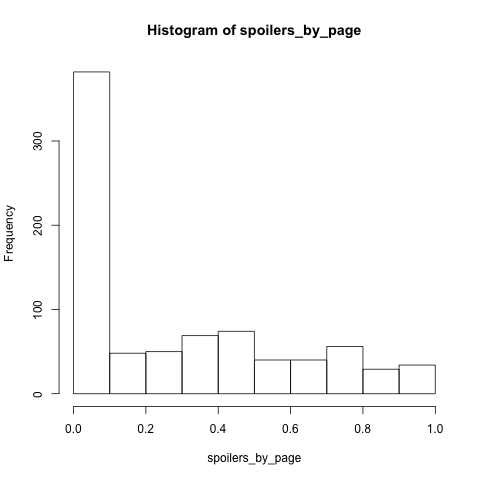

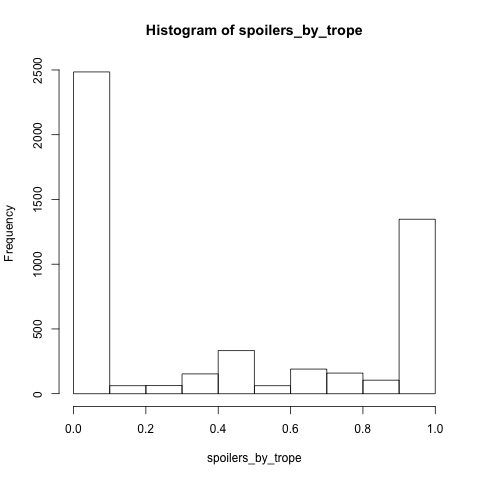

In [31]:
%%R
spoilers_by_page = tapply(train$spoiler, train$page, function(x) sum(x)/length(x))
hist(spoilers_by_page)
spoilers_by_page
    
spoilers_by_trope = tapply(train$spoiler, train$trope, function(x) sum(x)/length(x))
hist(spoilers_by_trope)
spoilers_by_trope

In [531]:
# Write most common words in spoilers to file, sorted by frequency
spoiler_sentences = train.loc[train['spoiler']==True]['sentence']
spoiler_text = ' '.join(spoiler_sentences)
spoiler_words = pd.DataFrame(word_tokenize(spoiler_text))
spoiler_word_frequencies = spoiler_words.apply(pd.value_counts)
spoiler_word_frequencies.to_csv('./spoiler_word_frequencies.csv')